In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import ttest_ind, pearsonr

In [2]:
!gdown --id 13Qm6ztAmVyBHvo_mch6gk-2VYKUHeRuu

Downloading...
From: https://drive.google.com/uc?id=13Qm6ztAmVyBHvo_mch6gk-2VYKUHeRuu
To: /content/inno_stats.tar.gz
1.91GB [00:34, 56.0MB/s]


In [3]:
!mkdir data 
!tar -xf inno_stats.tar.gz -C ./data

In [3]:
data_path = Path('./data/').resolve()
!ls {data_path}

09_groups.csv  10_groups.csv  11_groups.csv  product_groups.csv


In [4]:
group_9 = pd.read_csv('./data/09_groups.csv')
group_9.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


Frequent buyers


In [5]:
bad_ids = pd.read_csv('bad_ids.csv')

In [6]:
def clean_df(df):
  ids = set(bad_ids['id_card'])
  cleaned = df.copy()
  cleaned = cleaned[~cleaned['id_card'].isin(ids)]

  return cleaned

In [7]:
group_9_cleaned = clean_df(group_9)

In [9]:
freqs = group_9_cleaned.groupby(by=['id_doc']).first()
freqs['id_card'].value_counts()[:50]

620767     161
1523082    119
943480     109
1567258    104
1808366    103
1144271    103
1284105    102
297039     101
1789392     98
904949      98
1472222     91
926464      89
439307      86
789143      78
919837      78
74300       77
1108476     76
1334945     76
1229061     76
974512      76
748538      75
1095114     75
1572245     74
563042      74
1161780     73
1609030     73
365710      72
516949      72
1817230     71
1107018     71
869122      71
1249323     71
204545      70
490358      70
1335412     69
1818799     69
842795      69
971273      69
1745221     68
562286      68
487974      68
759554      68
661917      68
675545      68
1572850     67
1507020     67
1326765     67
1785077     67
1226636     67
1393925     67
Name: id_card, dtype: int64

In [10]:
del freqs

Prove that buying discounted products depends on the average order sum.

In [14]:
average = group_9_cleaned.groupby("id_doc")['sum'].mean().to_list()
is_green_sum = group_9_cleaned.groupby("id_doc")['is_green'].sum().to_list()
pearsonr(average, is_green_sum)

(-0.12120540985170064, 0.0)

Therefore, dependancy between average order sum and discounted products


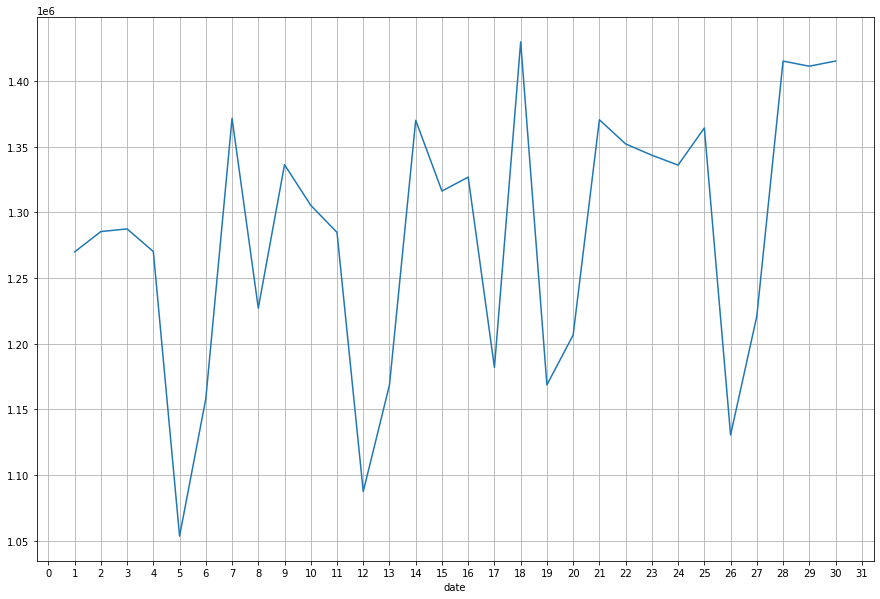

In [16]:
format = '%Y-%m-%d %H:%M:%S'
group_9_cleaned.index = pd.to_datetime(group_9_cleaned['date'],format=format)

spend = group_9_cleaned.groupby(by=[group_9_cleaned.index.day])['id_doc'].count()
plt.figure(figsize=(15,10))
plt.locator_params(axis="x", nbins=50)
spend.plot()
plt.grid()